**Validation Metrics**

This notebook accepts a trained model and outputs statistics of its performance.

* Performance on training, validation, and test set
* Plot our predictions versus assay output
* Overlap with conservation scores
* Overlap with CENTIPEDE motifs
* Scatter plot of our importance scores versus SHARPR scores
* ... Things I missed :)

**General Strategy for Importance Scores**

Let's try to get all types of importance scores into  nested dictionaries of the following spec:

(promoter, cell_type) -> chromosome -> position -> score


In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Load in Experimental Data and SHARPR Predictions

In [6]:
# This loads in the experimental data
from mrpa_data import MrpaData
data = MrpaData()

In [37]:
# Loads in SHARPR activity scores
sharpr = {}
for promoter in data.promoters:
    for cell_type in data.cell_types:
        experiment_key = (promoter, cell_type)
        sharpr[experiment_key] = {}
        with open("../data/sharpr_scores/wig/{}_{}.wig".format(promoter, cell_type)) as wig:
            for line in wig:
                if line[0] == '#': continue
                chrom, start, end, score = line.strip().split()
                start, end = int(start), int(end)
                score = float(score)
                if end - start > 1: continue
                if chrom not in sharpr[experiment_key]: sharpr[experiment_key][chrom] = {}
                for pos in range(start, end):
                    assert pos not in sharpr[experiment_key][chrom]
                    sharpr[experiment_key][chrom][pos] = score

# Make Predictions from trained model

In [39]:
model = load_model() ####

predictions = {} # experiment -> chrom -> pos -> score
activity = {}    # experiment -> chrom -> pos -> deeplift / ism score
for position in positions:
    seq = get_seq(*position)  ###
    deeplift = get_deeplift(seq) ####

NameError: name 'model' is not defined

Our predictions versus assay output

# Conservation Analysis

Using SiPhi scores obtained from: https://www.broadinstitute.org/mammals-models/29-mammals-project-supplementary-info

My understanding is that for each 12mer in the genome, they assessed the extent of conservation accross 29 mamalian genomes. They then reported 12mers at a FDR of 10%.

See the below plot for the quantile analysis.

I tried simply making a scatter plot and boxplot of the data, but it was a mess.

In [41]:
# Load in the data.
si_phi = {} # chrom, position, LOR (no entry implies not signiticant)
with open('../data/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt') as conservation:
    for line in conservation:
        chrom, start, end, lor, branch = line.strip().split()
        start, end, lor = int(start), int(end), float(lor)
        if chrom not in si_phi: si_phi[chrom] = {}
        for pos in range(start, end):
            si_phi[chrom][pos] = lor

In [55]:
for experiment, scores in sharpr.items():
    mrpa_conserve = []
    for chrom in scores:
        for pos in scores[chrom]:
            mrpa_conserve.append((scores[chrom][pos], si_phi[chrom][pos] if pos in si_phi[chrom] else 0))
    break

In [56]:
mrpa_conserve = sorted(mrpa_conserve, key = lambda x: x[0])

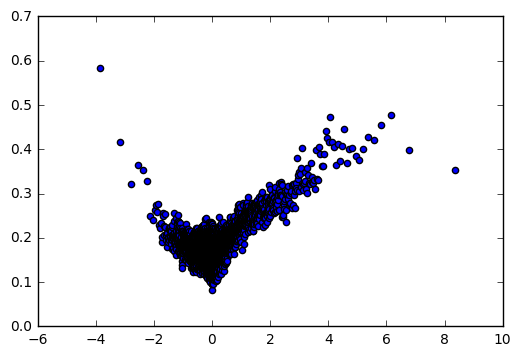

In [71]:
mrpa, conserve = [], []
quantiles = 5000
for i in range(0, len(mrpa_conserve), len(mrpa_conserve) / quantiles):
    index = range(i, min(i + (len(mrpa_conserve) / quantiles), len(mrpa_conserve)))
    activities = [mrpa_conserve[j][0] for j in index]
    conserves  = [bool(mrpa_conserve[j][1]) for j in index]
    
    mrpa.append(sum(activities) / float(len(activities)))
    conserve.append(sum(conserves) / float(len(conserves)))
plt.scatter(mrpa, conserve)
plt.show()
        